In [1]:
import os
import time
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from itertools import chain
from collections import Counter
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

/Users/patsnap/anaconda2/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
device = torch.device('cpu')
device

device(type='cpu')

In [3]:
datafile = '/Users/patsnap/Desktop/Neo4J_and_other_codes/1014-4361-bundle-archive/ner_dataset.csv'

In [4]:
df = pd.read_csv(datafile, encoding="latin1", error_bad_lines=False)
df = df.fillna(method='ffill')

In [5]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [6]:
len(df)

1048575

In [7]:
tags = list(df.Tag.unique())
tags

['O',
 'B-geo',
 'B-gpe',
 'B-per',
 'I-geo',
 'B-org',
 'I-org',
 'B-tim',
 'B-art',
 'I-art',
 'I-per',
 'I-gpe',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat']

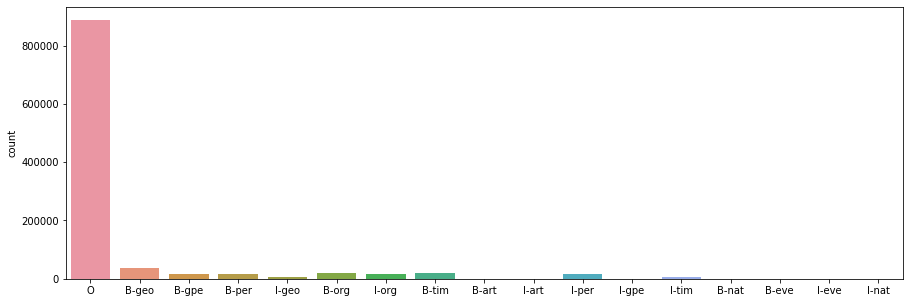

In [8]:
plt.figure(figsize=(15, 5))
sns.countplot(df.Tag.values)

In [9]:
num_tags = len(tags)
num_tags

17

In [10]:
agg_func = lambda s: [(w, t) for w, p, t in zip(s["Word"].values.tolist(), s["POS"].values.tolist(), s["Tag"].values.tolist())]
group = df.groupby("Sentence #").apply(agg_func)
lines = [s for s in group]


In [11]:
lines[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

In [12]:
sentences = [['<START>'] + [tokens[0] for tokens in line] + ['<END>'] for line in lines]
tags = [['<START>'] + [tokens[1] for tokens in line] + ['<END>'] for line in lines]

In [13]:
chars = [[['<START']] + [['<START>'] + [ch for ch in word] + ['<END>'] for word in sent[1:-1]] + [['<END>']] for sent in sentences]

In [14]:
len(sentences), len(tags), len(chars)

(47959, 47959, 47959)

In [15]:
sentences[0]

['<START>',
 'Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.',
 '<END>']

In [16]:
chars[0]

[['<START'],
 ['<START>', 'T', 'h', 'o', 'u', 's', 'a', 'n', 'd', 's', '<END>'],
 ['<START>', 'o', 'f', '<END>'],
 ['<START>',
  'd',
  'e',
  'm',
  'o',
  'n',
  's',
  't',
  'r',
  'a',
  't',
  'o',
  'r',
  's',
  '<END>'],
 ['<START>', 'h', 'a', 'v', 'e', '<END>'],
 ['<START>', 'm', 'a', 'r', 'c', 'h', 'e', 'd', '<END>'],
 ['<START>', 't', 'h', 'r', 'o', 'u', 'g', 'h', '<END>'],
 ['<START>', 'L', 'o', 'n', 'd', 'o', 'n', '<END>'],
 ['<START>', 't', 'o', '<END>'],
 ['<START>', 'p', 'r', 'o', 't', 'e', 's', 't', '<END>'],
 ['<START>', 't', 'h', 'e', '<END>'],
 ['<START>', 'w', 'a', 'r', '<END>'],
 ['<START>', 'i', 'n', '<END>'],
 ['<START>', 'I', 'r', 'a', 'q', '<END>'],
 ['<START>', 'a', 'n', 'd', '<END>'],
 ['<START>', 'd', 'e', 'm', 'a', 'n', 'd', '<END>'],
 ['<START>', 't', 'h', 'e', '<END>'],
 ['<START>', 'w', 'i', 't', 'h', 'd', 'r', 'a', 'w', 'a', 'l', '<END>'],
 ['<START>', 'o', 'f', '<END>'],
 ['<START>', 'B', 'r', 'i', 't', 'i', 's', 'h', '<END>'],
 ['<START>', 't', 'r',

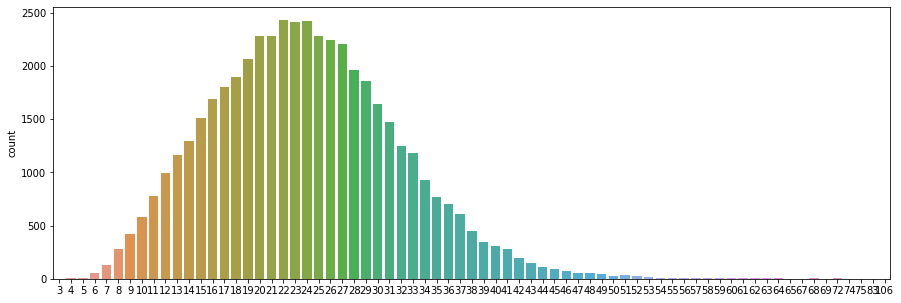

In [17]:
sen_lengths = [len(sent) for sent in sentences]
plt.figure(figsize=(15, 5))
sns.countplot(sen_lengths)

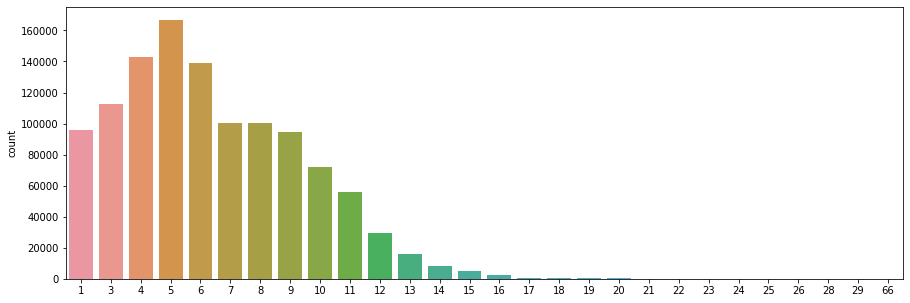

In [18]:
char_lengths = [len(t) for char in chars for t in char]
plt.figure(figsize=(15, 5))
sns.countplot(char_lengths)

In [19]:
train_sentences, valid_sentences, train_tags, valid_tags, train_chars, valid_chars = train_test_split(sentences, tags, chars, test_size=0.2, random_state=42)
valid_sentences, test_sentences, valid_tags, test_tags, valid_chars, test_chars = train_test_split(valid_sentences, valid_tags, valid_chars, test_size=0.5, random_state=42)
len(train_sentences), len(valid_sentences), len(test_sentences)

(38367, 4796, 4796)

In [20]:
class Vocab:
    def __init__(self, word2id, id2word):
        self.UNK = '<UNK>'
        self.PAD = '<PAD>'
        self.START = '<START>'
        self.END = '<END>'
        self.__word2id = word2id
        self.__id2word = id2word

    def get_word2id(self):
        return self.__word2id

    def get_id2word(self):
        return self.__id2word

    def __getitem__(self, item):
        if self.UNK in self.__word2id:
            return self.__word2id.get(item, self.__word2id[self.UNK])
        return self.__word2id[item]

    def __len__(self):
        return len(self.__word2id)

    def id2word(self, idx):
        return self.__id2word[idx]

In [21]:
def build_vocab(data, freq_cutoff=5, is_tags=False, is_chars=False):
    if is_chars:
        word_counts = Counter(chain(*chain(*train_chars[:10])))
    else:
        word_counts = Counter(chain(*data))
    valid_words = [w for w, d in word_counts.items() if d >= freq_cutoff]
    valid_words = sorted(valid_words, key=lambda x: word_counts[x], reverse=True)
    valid_words += ['<PAD>']
    word2id = {w: idx for idx, w in enumerate(valid_words)}
    if not is_tags:
        word2id['<UNK>'] = len(word2id)
        valid_words += ['<UNK>']
    return Vocab(word2id=word2id, id2word=valid_words)

In [22]:
words_vocab = build_vocab(train_sentences)
tags_vocab = build_vocab(train_tags, is_tags=True)
chars_vocab = build_vocab(train_chars, is_chars=True)

In [23]:
len(words_vocab), len(tags_vocab), len(chars_vocab)

(9620, 20, 34)

In [24]:
MAX_SEQ_LEN = 50
MAX_WORD_LEN = 15

In [25]:
class NERDataset(data.Dataset):
    def __init__(self, sentences, tags, chars, max_seq_len, max_word_len):
        self.sentences = sentences
        self.tags = tags
        self.characters = chars
        self.max_seq_len = max_seq_len
        self.max_word_len = max_word_len
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, item):
        sentence = self.sentences[item]
        tag = self.tags[item]
        chars = self.characters[item]
        seq_len = len(sentence)

        # convert the sentences and tags into numerical format
        word_tokens = [words_vocab[word] for word in sentence]
        tag_tokens = [tags_vocab[t] for t in tag]

        char_seq = []
        for word in chars:
            word_len = len(word)
            # truncate the word if it is greater than max_word_len
            if word_len > self.max_word_len:
                word = word[:self.max_word_len]
            # pad the word if it less
            else:
                pad_length = self.max_word_len - word_len
                word = word + [chars_vocab.PAD] * pad_length
            
            # convert the chars into numerical format
            char_ids = []
            for each_char in word: 
                char_ids.append(chars_vocab[each_char])
            char_seq.append(char_ids)
        
        return torch.LongTensor(word_tokens), torch.LongTensor(char_seq), torch.LongTensor(tag_tokens)

In [26]:
train_dataset = NERDataset(train_sentences, train_tags, train_chars, MAX_SEQ_LEN, MAX_WORD_LEN)
valid_dataset = NERDataset(valid_sentences, valid_tags, valid_chars, MAX_SEQ_LEN, MAX_WORD_LEN)
test_dataset = NERDataset(test_sentences, test_tags, test_chars, MAX_SEQ_LEN, MAX_WORD_LEN)

In [27]:
train_dataset[0]

(tensor([   1,  150,  235,   11,   36,   72,   49, 3318,    8, 1977, 4171,  166,
         9619, 9619, 7832,    4,  199,    7, 1385, 9619,   67, 1103,    3,    2]),
 tensor([[24, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32],
         [ 1, 28,  4, 14,  5, 11,  0, 32, 32, 32, 32, 32, 32, 32, 32],
         [ 1, 33,  4,  6,  2,  3,  0, 32, 32, 32, 32, 32, 32, 32, 32],
         [ 1, 29,  7,  0, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32],
         [ 1, 16,  4, 21,  2,  6,  8, 15,  2,  8,  5,  0, 32, 32, 32],
         [ 1, 33, 14,  2,  7, 10,  3, 19,  0, 32, 32, 32, 32, 32, 32],
         [ 1,  3, 12,  7,  4,  0, 32, 32, 32, 32, 32, 32, 32, 32, 32],
         [ 1, 14,  8, 21,  2,  9, 12,  2, 10,  0, 32, 32, 32, 32, 32],
         [ 1,  3,  0, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32],
         [ 1,  7,  4, 33, 13,  3, 12, 12,  2, 10,  0, 32, 32, 32, 32],
         [ 1, 33,  6,  2,  2,  8,  0, 32, 32, 32, 32, 32, 32, 32, 32],
         [ 1, 33,  2, 23,  0, 32, 32, 32, 32, 32, 32, 3

In [28]:
BATCH_SIZE = 64

In [29]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[0]), reverse=True)
    sentences, words, tags = zip(*data)

    # Merge questions (from tuple of 1D tensor to 2D tensor).
    sent_lengths = [len(sent) for sent in sentences]
    inputs = torch.zeros(len(sentences), max(sent_lengths)).long()
    labels = torch.zeros(len(sentences), max(sent_lengths)).long()
    chars = torch.zeros(len(sentences), max(sent_lengths), MAX_WORD_LEN).long()
    for i, (sent, lab, ch) in enumerate(zip(sentences, tags, words)):
        end = sent_lengths[i]
        inputs[i, :end] = sent[:end]
        labels[i, :end] = lab[:end]
        chars[i, :end] = ch[:end]
    return inputs, chars, labels, sent_lengths

In [30]:
train_data_loader = data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_data_loader = data.DataLoader(valid_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_data_loader = data.DataLoader(test_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [31]:
sample = next(iter(train_data_loader))

In [32]:
sample[0].shape, sample[1].shape, sample[2].shape, len(sample[3])

(torch.Size([64, 41]), torch.Size([64, 41, 15]), torch.Size([64, 41]), 64)

In [33]:
class CharBiLSTMCRF(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, char_emb_dim, char_hid_dim, char_vocab_size, tag_vocab_size, sent_pad_token, tag_start_token, dropout=0.3):
        super().__init__()
        self.hid_dim = hid_dim
        self.sent_pad_token = sent_pad_token
        self.tag_start_token = tag_start_token
        self.tag_vocab_size = tag_vocab_size

        self.char_embedding = nn.Embedding(char_vocab_size, char_emb_dim, padding_idx=0)
        self.char_lstm = nn.LSTM(char_emb_dim, char_hid_dim, bidirectional=True, batch_first=True)

        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            emb_dim + char_hid_dim,
            hid_dim,
            bidirectional=True,
            batch_first=True
        )
        self.emission = nn.Linear(hid_dim * 2, tag_vocab_size)
        self.transition = nn.Parameter(torch.rand(tag_vocab_size, tag_vocab_size))

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, sentences, lengths, words, tags):
        # sentences => [batch_size, seq_len]
        # lengths => [batch_size]
        # words => [batch_size, seq_len, word_len]
        # tags => [batch_size, seq_len]

        char_final_hidden = []
        for word in words:
            # word => [seq_len, word_len]
            char_embed = self.char_embedding(word)
            char_embed = self.dropout(char_embed)
            # char_embed => [seq_len, word_len, char_emb_dim]

            _, (char_hidden, _) = self.char_lstm(char_embed)
            # char_hidden => [2, seq_len, char_hid_dim]

            # add the final forward and backward hidden states
            char_combined = char_hidden[-1, :, :] + char_hidden[-2, :, :]
            # char_combined => [seq_len, char_hid_dim]

            char_final_hidden.append(char_combined)
        
        char_encoding = torch.stack(char_final_hidden)
        # char_encoding => [batch_size, seq_len, char_hid_dim]

        mask = (sentences != self.sent_pad_token).to(device)
        # mask => [batch_size, seq_len]

        embed = self.embedding(sentences)
        embed = self.dropout(embed)
        # embed => [batch_size, seq_len, emb_dim]

        embed_with_char = torch.cat((embed, char_encoding), dim=-1)
        # embed_with_char => [batch_size, seq_len, emb_dim + char_hid_dim]

        packed_input = nn.utils.rnn.pack_padded_sequence(embed_with_char, lengths, batch_first=True)
        packed_output, _ = self.lstm(packed_input)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        # outputs => [batch_size, seq_len, hid_dim * 2]

        combined = torch.cat((outputs[:, :, :self.hid_dim], outputs[:, :, self.hid_dim:]), dim=-1)
        combined = self.dropout(combined)
        # combined => [batch_size, seq_len, hid_dim * 2]

        emission_scores = self.emission(combined)
        # emission_scores => [batch_size, seq_len, tag_size]

        loss = self.vitebri_loss(tags, mask, emission_scores)
        # loss => [batch_size]

        return loss

    def vitebri_loss(self, tags, mask, emit_scores):
        # tags => [batch_size, seq_len]
        # mask => [batch_size, seq_len]
        # emit_scores => [batch_size, seq_len, tag_size]

        batch_size, sent_len = tags.shape

        # calculate the ground truth score
        score = torch.gather(emit_scores, 2, tags.unsqueeze(2)).squeeze(2)
        # emission scores of actual tags
        # score => [batch_size, seq_len]

        # add the transition scores to the emission scores
        # ignore the start token tag score
        score[:, 1:] += self.transition[tags[:, :-1], tags[:, 1:]]

        # consider only the scores of actual tokens not the padded
        gold_scores = (score * mask.type(torch.float)).sum(dim=1)
        # gold_scores => [batch_size]

        # calculate the scores of the partition (Z)
        # tensor to hold the accumulated sequence scores at each time step
        # at the inital time step score will be on dim=0
        scores_upto_t = emit_scores[:, 0].unsqueeze(1)
        # scores_upto_t => [batch_size, 1, tag_size]

        for i in range(1, sent_len):
            # get the current batch_size
            batch_t = mask[:, i].sum()

            # get the accumulated scores till now (only the current batch size)
            scores_unpad = scores_upto_t[:batch_t]
            # scores_unpad => [batch_t, 1, tag_size]

            # add the transition scores for this time step
            scores_with_trans = emit_scores[:batch_t, i].unsqueeze(1) + self.transition
            # scores_with_trans => [batch_t, tag_size, tag_size]

            # add to the accumulation
            sum_scores = scores_unpad.transpose(1, 2) + scores_with_trans
            # sum_scores => [batch_t, tag_size, tag_size]
            
            # apply the following to overcome the overflow problems
            # since the exp(some_big_number) will cause issues 
            # log(Σ exp(z_k)) = max(z) + log(Σ exp(z_k - max(z)))
            # log(Σ exp(z_k)) = log(Σ exp(z_k - c + c))
            #                 = log(Σ exp(z_k - c) * exp(c))
            #                 = log(Σ exp(z_k - c)) + log(exp(c))
            #                 = log(Σ exp(z_k - c)) + c
            # by taking c as max(z)
            # log(Σ exp(z_k)) = max(z) + log(Σ exp(z_k - max(z))) [log_sum_exp]
            # get the maximum score of the current time step
            max_t = sum_scores.max(dim=1)[0].unsqueeze(1)
            # max_t => [batch_t, 1, tag_size]

            sum_scores = sum_scores - max_t
            # sum_scores => [batch_t, tag_size, tag_size]

            scores_t = max_t + torch.logsumexp(sum_scores, dim=1).unsqueeze(1)
            # scores_t => [batch_t, 1, tag_size]

            # update the accumulation scores
            scores_upto_t = torch.cat((scores_t, scores_upto_t[batch_t:]), dim=0)
            # scores_upto_t => [batch_size, 1, tag_size]
        
        final_scores = scores_upto_t.squeeze(1)
        # final_scores => [batch_size, tag_size]

        max_final_scores = final_scores.max(dim=-1)[0]
        # max_final_scores => [batch_size]

        predicted_scores = max_final_scores + torch.logsumexp(final_scores - max_final_scores.unsqueeze(1), dim=1)
        # predicted_scores => [batch_size]

        vitebri_loss = predicted_scores - gold_scores
        # vitebri_loss => [batch_size]

        return vitebri_loss
    
    def predict(self, sentences, lengths, words):
        # sentences => [batch_size, seq_len]
        # lengths => [batch_size]
        # words => [batch_size, seq_len, word_len]

        batch_size = sentences.size(0)

        char_final_hidden = []
        for word in words:
            # word => [seq_len, word_len]
            char_embed = self.char_embedding(word)
            char_embed = self.dropout(char_embed)
            # char_embed => [seq_len, word_len, char_emb_dim]

            _, (char_hidden, _) = self.char_lstm(char_embed)
            # char_hidden => [2, seq_len, char_hid_dim]

            # add the final forward and backward hidden states
            char_combined = char_hidden[-1, :, :] + char_hidden[-2, :, :]
            # char_combined => [seq_len, char_hid_dim]

            char_final_hidden.append(char_combined)
        
        char_encoding = torch.stack(char_final_hidden)
        # char_encoding => [batch_size, seq_len, char_hid_dim]

        mask = (sentences != self.sent_pad_token).to(device)
        # mask => [batch_size, seq_len]

        embed = self.embedding(sentences)
        embed = self.dropout(embed)
        # embed => [batch_size, seq_len, emb_dim]

        embed_with_char = torch.cat((embed, char_encoding), dim=-1)
        # embed_with_char => [batch_size, seq_len, emb_dim + char_hid_dim]

        packed_inp = nn.utils.rnn.pack_padded_sequence(embed_with_char, lengths, batch_first=True)
        packed_output, _ = self.lstm(packed_inp)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        # outputs => [batch_size, seq_len, hid_dim * 2]

        combined = torch.cat((outputs[:, :, :self.hid_dim], outputs[:, :, self.hid_dim:]), dim=-1)
        combined = self.dropout(combined)
        # combined => [batch_size, seq_len, hid_dim * 2]

        emission_scores = self.emission(combined)
        # emission_scores => [batch_size, seq_len, tag_size]

        # to store the tags predicted at each time step
        # since at the begining every tag is start tag create the list with start tags
        tags = [[[self.tag_start_token] for _ in range(self.tag_vocab_size)]] * batch_size
        # tags => [batch_size, tag_size, 1]

        scores_upto_t = emission_scores[:, 0].unsqueeze(1)
        # scores_upto_t => [batch_size, 1, tag_size]

        for i in range(1, max(lengths)):
            # get the current batch_size
            batch_t = mask[:, i].sum()

            # get the accumulated scores till now (only the current batch size)
            scores_unpad = scores_upto_t[:batch_t]
            # scores_unpad => [batch_t, 1, tag_size]

            # add the transition scores for this time step
            scores_with_trans = emission_scores[:batch_t, i].unsqueeze(1) + self.transition
            # scores_with_trans => [batch_t, tag_size, tag_size]

            # add to the accumulation
            sum_scores = scores_unpad.transpose(1, 2) + scores_with_trans
            # sum_scores => [batch_t, tag_size, tag_size]

            max_scores_t, max_ids_t = torch.max(sum_scores, dim=1)
            max_ids_t = max_ids_t.tolist()
            # max_scores_t => [batch_t, tag_size]
            # max_ids_t => [batch_t, tag_size]

            # add the current time step predicted tags 
            tags[:batch_t] = [[tags[b][k] + [j] for j, k in enumerate(max_ids_t[b])] for b in range(batch_t)]
            
            # update the accumulation scores
            scores_upto_t = torch.cat((max_scores_t.unsqueeze(1), scores_upto_t[batch_t:]), dim=0)
            # scores_upto_t => [batch_size, tag_size]

        scores = scores_upto_t.squeeze(1)
        # scores => [batch_size, tag_size]

        _, max_ids = torch.max(scores, dim=1)
        max_ids = max_ids.tolist()
        # max_ids => [batch_size]

        # tags => [batch_size, tag_size, seq_len]
        tags = [tags[b][k] for b, k in enumerate(max_ids)]
        # tags => [batch_size, seq_len]

        return tags

In [34]:
vocab_size = len(words_vocab)
sent_pad_token = words_vocab[words_vocab.PAD]
tag_start_token = tags_vocab[tags_vocab.START]
emb_dim = 50
hid_dim = 200
char_emb_dim = 20
char_hid_dim = 50
char_vocab_size = len(chars_vocab)
tag_vocab_size = len(tags_vocab)
model = CharBiLSTMCRF(
    vocab_size,
    emb_dim,
    hid_dim,
    char_emb_dim,
    char_hid_dim,
    char_vocab_size,
    tag_vocab_size,
    sent_pad_token,
    tag_start_token
)
model.to(device)

CharBiLSTMCRF(
  (char_embedding): Embedding(34, 20, padding_idx=0)
  (char_lstm): LSTM(20, 50, batch_first=True, bidirectional=True)
  (embedding): Embedding(9620, 50, padding_idx=0)
  (lstm): LSTM(100, 200, batch_first=True, bidirectional=True)
  (emission): Linear(in_features=400, out_features=20, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,002,100 trainable parameters


In [36]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [37]:
def train(model, iterator, optimizer, clip):
    model.train()

    epoch_loss = 0
    total_sentences = 0

    for batch in iterator:
        sentences = batch[0].to(device)
        words = batch[1].to(device)
        tags = batch[2].to(device)
        seq_lengths = batch[3]
        # sentences => [batch_size, seq_len]
        # words => [batch_size, seq_len, word_len]
        # tags => [batch_size, seq_len]
        # seq_lengths => [batch_size]

        optimizer.zero_grad()

        batch_loss = model(sentences, seq_lengths, words, tags)
        # batch_loss => [batch_size]

        loss = batch_loss.mean()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += batch_loss.sum().item()
        total_sentences += len(sentences)

    return epoch_loss / total_sentences

In [38]:
def evaluate(model, iterator):
    model.eval()
    epoch_loss = 0
    total_sentences = 0

    with torch.no_grad():
        for batch in iterator:
            sentences = batch[0].to(device)
            words = batch[1].to(device)
            tags = batch[2].to(device)
            seq_lengths = batch[3]
            # sentences => [batch_size, seq_len]
            # words => [batch_size, seq_len, word_len]
            # tags => [batch_size, seq_len]
            # seq_lengths => [batch_size]

            batch_loss = model(sentences, seq_lengths, words, tags)
            # batch_loss => [batch_size]

            loss = batch_loss.mean()

            epoch_loss += batch_loss.sum().item()
            total_sentences += len(sentences)
        
    return epoch_loss / total_sentences

In [39]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [40]:
N_EPOCHS = 10
CLIP = 2
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss = train(model, train_data_loader, optimizer, CLIP)
    valid_loss = evaluate(model, valid_data_loader)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 13m 58s
	Train Loss: 7.989 | Val. Loss: 1.731
Epoch: 02 | Epoch Time: 13m 38s
	Train Loss: 1.768 | Val. Loss: 1.542
Epoch: 03 | Epoch Time: 13m 16s
	Train Loss: 1.580 | Val. Loss: 1.482
Epoch: 04 | Epoch Time: 13m 17s
	Train Loss: 1.491 | Val. Loss: 1.495
Epoch: 05 | Epoch Time: 13m 15s
	Train Loss: 1.438 | Val. Loss: 1.443
Epoch: 06 | Epoch Time: 13m 17s
	Train Loss: 1.389 | Val. Loss: 1.488
Epoch: 07 | Epoch Time: 13m 17s
	Train Loss: 1.359 | Val. Loss: 1.486
Epoch: 08 | Epoch Time: 13m 22s
	Train Loss: 1.341 | Val. Loss: 1.439
Epoch: 09 | Epoch Time: 13m 25s
	Train Loss: 1.328 | Val. Loss: 1.508
Epoch: 10 | Epoch Time: 13m 25s
	Train Loss: 1.304 | Val. Loss: 1.505


In [41]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [42]:
test_loss = evaluate(model, test_data_loader)
print(f'Test Loss: {test_loss:.3f}')

Test Loss: 1.422


In [43]:
def cal_metrics(model, iterator):
    model.eval()

    fin_outputs = []
    fin_targets = []

    with torch.no_grad():
        for batch in iterator:
            sentences = batch[0].to(device)
            words = batch[1].to(device)
            tags = batch[2].to(device)
            seq_lengths = batch[3]
            # sentences => [batch_size, seq_len]
            # words => [batch_size, seq_len, word_len]
            # tags => [batch_size, seq_len]
            # seq_lengths => [batch_size]

            predictions = model.predict(sentences, seq_lengths, words)
            # predictions => [batch_size, seq_len]

            fin_outputs.extend(predictions)
            fin_targets.extend(tags.detach().cpu().numpy().tolist())
        
    assert len(fin_outputs) == len(fin_targets)
    mlb = MultiLabelBinarizer()
    trans_trg = mlb.fit_transform(fin_targets)
    trans_pred = mlb.transform(fin_outputs)

    cf = metrics.classification_report(trans_trg, trans_pred)
    print(cf)

In [44]:
cal_metrics(model, test_data_loader)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4796
           1       1.00      1.00      1.00      4796
           2       1.00      1.00      1.00      4796
           3       0.92      0.96      0.94      2496
           4       0.97      0.95      0.96      1688
           5       0.90      0.78      0.84      1623
           6       0.90      0.96      0.93      1071
           7       0.91      0.91      0.91      1361
           8       0.87      0.80      0.84       879
           9       0.98      0.94      0.96      1303
          10       0.81      0.88      0.84       595
          11       0.87      0.80      0.84       395
          12       0.33      0.02      0.04        42
          13       0.87      0.42      0.57        31
          14       0.00      0.00      0.00        25
          15       0.67      0.25      0.36        16
          16       1.00      0.73      0.85        15
          17       0.86    

/Users/patsnap/anaconda2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
def inference(sentence):
    if isinstance(sentence, str):
        tokens = [words_vocab[words_vocab.START]] + sentence.split() + [words_vocab[words_vocab.END]]
    else:
        tokens = sentence
    
    chars = [['<START']] + [['<START>'] + [ch for ch in word] + ['<END>'] for word in tokens[1:-1]] + [['<END>']]

    char_seq = []
    for word in chars:
        word_len = len(word)
        # truncate the word if it is greater than max_word_len
        if word_len > MAX_WORD_LEN:
            word = word[:MAX_WORD_LEN]
        # pad the word if it less
        else:
            pad_length = MAX_WORD_LEN - word_len
            word = word + [chars_vocab.PAD] * pad_length
        
        # convert the chars into numerical format
        char_ids = []
        for each_char in word: 
            char_ids.append(chars_vocab[each_char])
        char_seq.append(char_ids)

    # numericalize
    token_ids = [words_vocab[tok] for tok in tokens]
    
    # seq length
    sent_length = [len(token_ids)]

    # create tensors
    sent_tensor = torch.LongTensor(token_ids).to(device)
    sent_tensor = sent_tensor.unsqueeze(0)
    # sent_tensor => [1, seq_len]

    char_tensor = torch.LongTensor(char_seq).to(device)
    char_tensor = char_tensor.unsqueeze(0)
    # char_tensor => [1, seq_len, word_len]

    model.eval()
    with torch.no_grad():
        predictions = model.predict(sent_tensor, sent_length, char_tensor)
    
    predictions = predictions[0]
    predicted_tags = []
    for i in predictions:
        predicted_tags.append(tags_vocab.id2word(i))
    
    return tokens, predicted_tags

In [46]:
sentence = test_sentences[0]
actual_tags = test_tags[0]
tokens, predicted_tag_ids = inference(sentence)

print("Pred. Tag\tActual Tag\tCorrect?\tToken\n")
for token, pred_tag, actual_tag in zip(tokens, predicted_tag_ids, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    print(f"{pred_tag}\t\t{actual_tag}\t\t{correct}\t\t{token}")

Pred. Tag	Actual Tag	Correct?	Token

<START>		<START>		✔		<START>
O		O		✔		The
O		O		✔		office
O		O		✔		of
O		O		✔		the
B-gpe		B-gpe		✔		Israeli
O		O		✔		prime
O		O		✔		minister
O		O		✔		says
O		O		✔		a
O		O		✔		visit
O		O		✔		to
B-geo		B-geo		✔		Israel
O		O		✔		by
O		O		✔		the
O		O		✔		foreign
O		O		✔		ministers
O		O		✔		of
B-geo		B-gpe		✘		Egypt
O		O		✔		and
B-gpe		B-gpe		✔		Jordan
O		O		✔		will
O		O		✔		take
O		O		✔		place
B-tim		B-tim		✔		July
I-tim		I-tim		✔		25
O		O		✔		,
O		O		✔		not
O		O		✔		this
O		O		✔		week
O		O		✔		as
O		O		✔		previously
O		O		✔		planned
O		O		✔		.
<END>		<END>		✔		<END>


In [47]:
sentence = test_sentences[10]
actual_tags = test_tags[10]
tokens, predicted_tag_ids = inference(sentence)

print("Pred. Tag\tActual Tag\tCorrect?\tToken\n")
for token, pred_tag, actual_tag in zip(tokens, predicted_tag_ids, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    print(f"{pred_tag}\t\t{actual_tag}\t\t{correct}\t\t{token}")

Pred. Tag	Actual Tag	Correct?	Token

<START>		<START>		✔		<START>
O		O		✔		An
B-gpe		B-gpe		✔		Iraqi
O		O		✔		militant
O		O		✔		group
O		O		✔		(
O		O		✔		the
B-org		B-org		✔		Islamic
I-org		I-org		✔		Army
O		O		✔		of
B-geo		B-geo		✔		Iraq
O		O		✔		)
O		O		✔		posted
O		O		✔		a
O		O		✔		video
O		O		✔		on
O		O		✔		the
O		O		✔		Internet
B-tim		B-tim		✔		today
O		O		✔		that
O		O		✔		showed
O		O		✔		a
O		O		✔		blindfolded
O		O		✔		man
O		O		✔		being
O		O		✔		shot
O		O		✔		in
O		O		✔		the
O		O		✔		back
O		O		✔		of
O		O		✔		the
O		O		✔		head
O		O		✔		.
<END>		<END>		✔		<END>


In [48]:
sentence = "I like to live in New York"
tokens, predicted_tag_ids = inference(sentence)

print("Pred. Tag\tToken\n")
for token, pred_tag in zip(tokens[1:-1], predicted_tag_ids[1:-1]):
    print(f"{pred_tag}\t\t{token}")

Pred. Tag	Token

O		I
O		like
O		to
O		live
O		in
B-geo		New
I-geo		York


In [49]:
sentence = "My dream is to work at Google"
tokens, predicted_tag_ids = inference(sentence)

print("Pred. Tag\tToken\n")
for token, pred_tag in zip(tokens[1:-1], predicted_tag_ids[1:-1]):
    print(f"{pred_tag}\t\t{token}")

Pred. Tag	Token

O		My
O		dream
O		is
O		to
O		work
O		at
B-org		Google
